In [146]:
import requests
import numpy as np
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from shapely.geometry import LineString, Polygon, Point
from shapely import wkt
from shapely.ops import transform
import geojson
import pyproj
from functools import partial

In [8]:
acc_layer = gp.read_file('app/static/acc_layer.geojson')

In [135]:
project = partial(
    pyproj.transform,
    pyproj.Proj(init='EPSG:4326'),
    pyproj.Proj(init='EPSG:32633'))

def get_geo_dist(line):
    line_proj = transform(project, line)
    return line_proj.length/1000.

def find_nearest_seg(point, lines, thresh=1E-5, return_dist=False):
    dist = lines.distance(point)
    id = dist.idxmin()
    return id if dist[id] < thresh else None

def get_accident_threat(acc_layer,route,alpha=1.):
    threat = 0
    total_distance = 0
    for line in route:
        indx = find_nearest_seg(line,acc_layer)
        d = get_geo_dist(line)
        if indx:
            total_distance += d
            threat += alpha*acc_layer.loc[indx].acc_prob + (1-alpha)*d
        else:
            print('Failed',d)
    return threat, total_distance


def segment_route(route,custom_route=None):
    
    if custom_route:
        lines = custom_route
    else:
        lines = geojson.loads(route)['routes'][0]['geometry']['coordinates']
    
    N = len(lines)
    segments = []
    if N > 2:
    
        start = tuple(lines[0])

        for i in range(N-1):
            end = tuple(lines[i+1])

            lstring = LineString([start,end])
            #lstring = wkt.loads("Linestring([{l1},{l2}])".format(l1=start,l2=end))
            start = end
            segments.append(lstring)
        return segments
    else:
        return [LineString(lines)]

In [58]:
P1 = [-118.410673,34.066666],
P2 = [-118.383475,34.055582],
x = requests.get("https://api.mapbox.com/directions/v5/mapbox/cycling/-118.410673,34.066666;-118.383475,34.055582?&geometries=geojson&access_token=pk.eyJ1Ijoic2hrYXJsZW4iLCJhIjoiY2p3d20wM252MGxoazQzbjU4aHFoOWMybCJ9.kF_uQSONrElBOKGGDGMPmg")

In [91]:
segs = segment_route(x.text)

In [101]:
geojson.loads(x.text)['routes']

[{'geometry': {"coordinates": [[-118.410707, 34.066701], [-118.410265, 34.066914], [-118.410492, 34.066664], [-118.410325, 34.066501], [-118.409997, 34.066727], [-118.410005, 34.065009], [-118.384624, 34.064978], [-118.384738, 34.057106], [-118.383665, 34.057098], [-118.383691, 34.055585]], "type": "LineString"},
  'legs': [{'summary': '',
    'weight': 1025.4,
    'duration': 988.1,
    'steps': [],
    'distance': 3830.3}],
  'weight_name': 'cyclability',
  'weight': 1025.4,
  'duration': 988.1,
  'distance': 3830.3}]

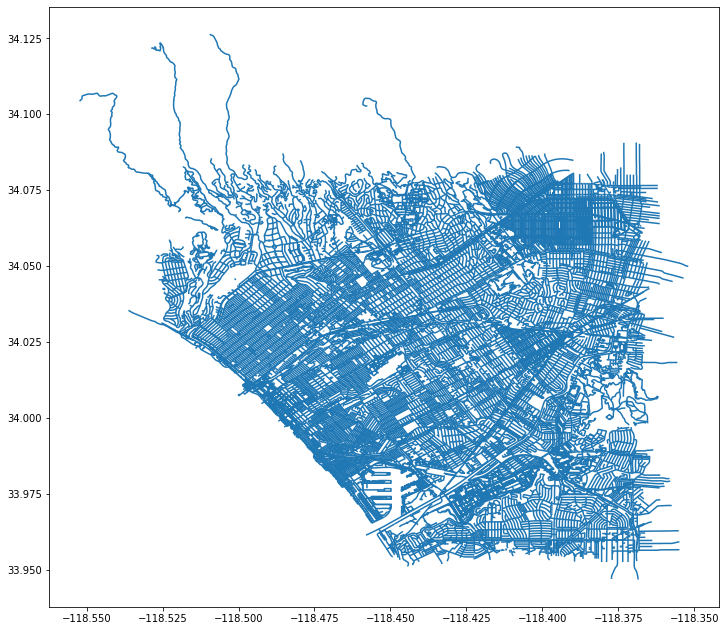

In [71]:
acc_layer.plot(figsize=(12,12))

In [139]:
get_accident_threat(acc_layer,segs,alpha=1)

FUUUUUUK 0.05904831823276808


(3.804458220493057, 4.724267372326715)

In [105]:
my_route = np.genfromtxt("/Users/karlen/Work/Insight/BikesploreLA/app/static/tmp.txt",names=['lat','lon'])

In [113]:
my_points = [ [lon,lat] for lon,lat in zip(my_route['lon'],my_route['lat']) ]

In [116]:
my_segs = segment_route(None,custom_route=my_points)

In [138]:
get_accident_threat(acc_layer,my_segs,alpha=1)

(15.545248209176016, 5.032376668513175)

In [151]:
volfile = "/Users/karlen/Work/Insight/data/raw/bike_traffic_volume/All_LocationsExport.csv"
vol_loc_df = pd.read_csv(volfile)

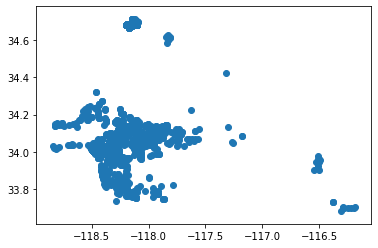

In [160]:
vol_loc_df = vol_loc_df[vol_loc_df.longitude < -90]
plt.scatter(vol_loc_df.longitude,vol_loc_df.latitude)

In [161]:
vol_loc_df.shape

(1231, 9)